# Energy Project CLustering and MLM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Required Libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


**Import from Big Query**


In [ ]:
from google.colab import auth
from google.cloud import bigquery

# 1. Authentifizierung
auth.authenticate_user()

# 2. BigQuery-Client mit expliziter Projekt-ID erstellen
client = bigquery.Client(project="data-analytics-final-prject")

# 3. Tabellen und Dateinamen definieren
tables = {
    "data-analytics-final-prject.final_project_cleaned.electricity_production_sources_new": "electricity_production_sources_new.csv",
    "data-analytics-final-prject.final_project_cleaned.annual_co2_emissions": "annual_co2_emissions.csv",
    "data-analytics-final-prject.final_project_cleaned.Continents": "continents.csv",
    "data-analytics-final-prject.final_project_cleaned.population_new": "population_new.csv",
    "data-analytics-final-prject.final_project_cleaned.emissions_by_sector_new": "emissions_by_sector_new.csv",
    "data-analytics-final-prject.final_project_cleaned.gdp_wb_clean": "gdp.csv",
    "data-analytics-final-prject.final_project_looker_datasets.clustering_table": "clustering_table.csv"
}

# 4. Tabellen abfragen und speichern
for table_id, file_name in tables.items():
    print(f"Importiere Tabelle: {table_id}")
    try:
        query = f"SELECT * FROM `{table_id}`"
        df = client.query(query).to_dataframe()
        df.to_csv(file_name, index=False)
        print(f"Tabelle {table_id} wurde als {file_name} gespeichert.\n")
    except Exception as e:
        print(f"Fehler beim Importieren der Tabelle {table_id}: {e}")

print("Import abgeschlossen!")

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# Importiere Tables
df_electricity = pd.read_csv("electricity_production_sources_new.csv")
df_emissions = pd.read_csv("annual_co2_emissions.csv")
df_continents = pd.read_csv("continents.csv")
df_population = pd.read_csv("population_new.csv")
df_emissions_by_sector = pd.read_csv("emissions_by_sector_new.csv")
cluster_data_2 = pd.read_csv("clustering_table.csv")
# Overview Tables
print("Electricity Production Sources:")
print(df_electricity.info())

print("\nAnnual CO2 Emissions:")
print(df_emissions.info())

print("\nContinents:")
print(df_continents.info())

print("\nPopulation:")
print(df_population.info())

print("\nEmissions by Sector:")
print(df_emissions_by_sector.info())


NameError: name 'pd' is not defined

**Configuration of the Timeframe**

In [ ]:
# define timeframe
start_year = 2012
end_year = 2021

# Filter
df_electricity_filtered = df_electricity[(df_electricity["Year"] >= start_year) & (df_electricity["Year"] <= end_year)]
df_emissions_filtered = df_emissions[(df_emissions["Year"] >= start_year) & (df_emissions["Year"] <= end_year)]
df_population_filtered = df_population[(df_population["Year"] >= start_year) & (df_population["Year"] <= end_year)]

# filter Continents
df_continents_filtered = df_continents


In [ ]:
# Number of rows after filtering
print("Electricity Production Sources (2013–2023):", len(df_electricity_filtered))
print("Annual CO2 Emissions (2013–2023):", len(df_emissions_filtered))
print("Population (2013–2023):", len(df_population_filtered))


Electricity Production Sources (2013–2023): 2068
Annual CO2 Emissions (2013–2023): 2160
Population (2013–2023): 2370


In [ ]:
# Check unique entities (countries) in each dataset
print("Electricity Production Entities:", df_electricity_filtered['Entity'].nunique())
print("Annual CO2 Emissions Entities:", df_emissions_filtered['Entity'].nunique())
print("Population Entities:", df_population_filtered['Entity'].nunique())

# Check unique years in each dataset
print("Electricity Production Years:", df_electricity_filtered['Year'].nunique())
print("Annual CO2 Emissions Years:", df_emissions_filtered['Year'].nunique())
print("Population Years:", df_population_filtered['Year'].nunique())


Electricity Production Entities: 207
Annual CO2 Emissions Entities: 216
Population Entities: 237
Electricity Production Years: 10
Annual CO2 Emissions Years: 10
Population Years: 10


In [ ]:
# Unique entities in each dataset
electricity_entities = set(df_electricity_filtered['Entity'].unique())
emissions_entities = set(df_emissions_filtered['Entity'].unique())
population_entities = set(df_population_filtered['Entity'].unique())

# Common entities
common_entities = electricity_entities & emissions_entities & population_entities
print("Number of common entities:", len(common_entities))

# Entities not shared across all datasets
only_in_electricity = electricity_entities - common_entities
only_in_emissions = emissions_entities - common_entities
only_in_population = population_entities - common_entities

print("Entities only in Electricity:", only_in_electricity)
print("Entities only in Emissions:", only_in_emissions)
print("Entities only in Population:", only_in_population)


Number of common entities: 200
Entities only in Electricity: {'Falkland Islands', 'Puerto Rico', 'Guam', 'Cayman Islands', 'American Samoa', 'Gibraltar', 'United States Virgin Islands'}
Entities only in Emissions: {'Tuvalu', 'Bonaire Sint Eustatius and Saba', 'Christmas Island', 'Micronesia (country)', 'Palau', 'Sri Lanka', 'Liechtenstein', 'Curacao', 'Wallis and Futuna', 'Singapore', 'Marshall Islands', 'Andorra', 'Anguilla', 'United Arab Emirates', 'Antarctica', 'Sint Maarten (Dutch part)'}
Entities only in Population: {'Tuvalu', 'Western Sahara', 'Jersey', 'Guernsey', 'Palau', 'Sri Lanka', 'Marshall Islands', 'Andorra', 'Gibraltar', 'Saint Martin (French part)', 'Mayotte', 'Falkland Islands', 'San Marino', 'Monaco', 'Guam', 'Guadeloupe', 'Northern Mariana Islands', 'Martinique', 'Sint Maarten (Dutch part)', 'Bonaire Sint Eustatius and Saba', 'Saint Barthelemy', 'Wallis and Futuna', 'Tokelau', 'Cayman Islands', 'Curacao', 'American Samoa', 'United Arab Emirates', 'French Guiana', 'Re

In [ ]:
# Merge datasets on Entity and Year
merged_data = df_electricity_filtered.merge(df_emissions_filtered, on=["Entity", "Year"], how="inner")
merged_data = merged_data.merge(df_population_filtered, on=["Entity", "Year"], how="inner")

# Check merged data
print("Rows after merging:", len(merged_data))
print("Merged Data Overview:")
print(merged_data.info())


Rows after merging: 1998
Merged Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1998 entries, 0 to 1997
Data columns (total 22 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Entity                                                 1998 non-null   object 
 1   Code_x                                                 1998 non-null   object 
 2   Year                                                   1998 non-null   int64  
 3   Other_renewables_excluding_bioenergy_TWh               1998 non-null   float64
 4   Electricity_from_bioenergy_TWh                         1998 non-null   float64
 5   Electricity_from_solar_TWh                             1998 non-null   float64
 6   Electricity_from_wind_TWh                              1998 non-null   float64
 7   Electricity_from_hydro_TWh                             1998 non-null   float64
 8   E

In [ ]:
# Load the emissions by sector dataset
df_emissions_by_sector = pd.read_csv("emissions_by_sector_new.csv")

# Create a new column for total emissions across all sectors
df_emissions_by_sector['total_emissions'] = df_emissions_by_sector[
    [
        'Greenhouse_gas_emissions_from_agriculture',
        'Greenhouse_gas_emissions_from_waste',
        'Greenhouse_gas_emissions_from_buildings',
        'Greenhouse_gas_emissions_from_industry',
        'Greenhouse_gas_emissions_from_manufacturing_and_construction',
        'Greenhouse_gas_emissions_from_transport',
        'Greenhouse_gas_emissions_from_electricity_and_heat',
        'Fugitive_emissions_of_greenhouse_gases_from_energy_production',
        'Greenhouse_gas_emissions_from_other_fuel_combustion',
        'Greenhouse_gas_emissions_from_bunker_fuels'
    ]
].sum(axis=1)

# Filter the data for the timeframe 2013-2023
df_emissions_by_sector_filtered = df_emissions_by_sector[
    (df_emissions_by_sector['Year'] >= 2014) & (df_emissions_by_sector['Year'] <= 2023)
]

# Verify the filtered data
print(df_emissions_by_sector_filtered.head())
print(f"Shape of the filtered dataset: {df_emissions_by_sector_filtered.shape}")

# Merge the filtered emissions data with your main dataset
# Replace `df_main` with the DataFrame you want to merge with
df_main_merged = pd.merge(
    merged_data,  # Your main dataset (e.g., annual emissions or population)
    df_emissions_by_sector_filtered[['Entity', 'Year', 'total_emissions']],
    on=['Entity', 'Year'],
    how='left'
)

# Verify the merged dataset
print(df_main_merged.head())
print(f"Shape of the merged dataset: {df_main_merged.shape}")


         Entity Code  Year  Greenhouse_gas_emissions_from_agriculture  \
24  Afghanistan  AFG  2014                                 16219999.0   
25  Afghanistan  AFG  2015                                 15540000.0   
26  Afghanistan  AFG  2016                                 15300000.0   
27  Afghanistan  AFG  2017                                 15200000.0   
28  Afghanistan  AFG  2018                                 15360000.0   

    Greenhouse_gas_emissions_from_land_use_change_and_forestry  \
24                                          -250000.0            
25                                          -250000.0            
26                                           150000.0            
27                                           150000.0            
28                                           150000.0            

    Greenhouse_gas_emissions_from_waste  \
24                            3190000.0   
25                            3280000.0   
26                            33700

In [ ]:
print(df_main_merged.isnull().sum())
print(df_main_merged.head())


Entity                                                     0
Code_x                                                     0
Year                                                       0
Other_renewables_excluding_bioenergy_TWh                   0
Electricity_from_bioenergy_TWh                             0
Electricity_from_solar_TWh                                 0
Electricity_from_wind_TWh                                  0
Electricity_from_hydro_TWh                                 0
Electricity_from_nuclear_TWh                               0
Electricity_from_oil_TWh                                   0
Electricity_from_gas_TWh                                   0
Electricity_from_coal_TWh                                  0
join_key_x                                                 0
share_of_renewable_energies                               10
Code_y                                                     0
annual_co2_emissions                                       0
Total_Annual_Emissions  

In [ ]:
# Display rows with missing values in 'share_of_renewable_energies'
missing_data = df_main_merged[df_main_merged['share_of_renewable_energies'].isnull()]
print("Rows with missing values in 'share_of_renewable_energies':")
print(missing_data)


Rows with missing values in 'share_of_renewable_energies':
   Entity Code_x  Year  Other_renewables_excluding_bioenergy_TWh  \
70   Niue    NIU  2012                                       0.0   
71   Niue    NIU  2013                                       0.0   
72   Niue    NIU  2014                                       0.0   
73   Niue    NIU  2015                                       0.0   
74   Niue    NIU  2016                                       0.0   
75   Niue    NIU  2017                                       0.0   
76   Niue    NIU  2018                                       0.0   
77   Niue    NIU  2019                                       0.0   
78   Niue    NIU  2020                                       0.0   
79   Niue    NIU  2021                                       0.0   

    Electricity_from_bioenergy_TWh  Electricity_from_solar_TWh  \
70                             0.0                         0.0   
71                             0.0                         0

In [ ]:
merged_data = df_main_merged.dropna(subset=['share_of_renewable_energies', "total_emissions"])
print("Rows after dropping missing values:", len(merged_data))


Rows after dropping missing values: 1464


In [ ]:
# Check for remaining missing values
print(merged_data.isnull().sum())


Entity                                                   0
Code_x                                                   0
Year                                                     0
Other_renewables_excluding_bioenergy_TWh                 0
Electricity_from_bioenergy_TWh                           0
Electricity_from_solar_TWh                               0
Electricity_from_wind_TWh                                0
Electricity_from_hydro_TWh                               0
Electricity_from_nuclear_TWh                             0
Electricity_from_oil_TWh                                 0
Electricity_from_gas_TWh                                 0
Electricity_from_coal_TWh                                0
join_key_x                                               0
share_of_renewable_energies                              0
Code_y                                                   0
annual_co2_emissions                                     0
Total_Annual_Emissions                                  

In [ ]:
pre_clust = merged_data[["Year","Entity", "share_of_renewable_energies", "annual_co2_emissions","total_emissions"]]
pre_clust["evolution_of_renewable_energies"] =pre_clust["share_of_renewable_energies"]

<ipython-input-16-890bdbfd5999>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_clust["evolution_of_renewable_energies"] =pre_clust["share_of_renewable_energies"]


In [ ]:
pre_clust[pre_clust["annual_co2_emissions"]== 0]

,Year,Entity,share_of_renewable_energies,annual_co2_emissions,total_emissions,evolution_of_renewable_energies


In [ ]:
pre_clust[pre_clust["share_of_renewable_energies"]== 0]

,Year,Entity,share_of_renewable_energies,annual_co2_emissions,total_emissions,evolution_of_renewable_energies
82,2014,Oman,0.0,65911436.0,9.399000e+07,0.0
83,2015,Oman,0.0,67590296.0,9.873000e+07,0.0
84,2016,Oman,0.0,65925070.0,1.035500e+08,0.0
122,2014,Benin,0.0,4796000.0,1.182000e+07,0.0
123,2015,Benin,0.0,5332540.0,1.223000e+07,0.0
...,...,...,...,...,...,...
1894,2016,Antigua and Barbuda,0.0,597232.0,1.560000e+06,0.0
1902,2014,Trinidad and Tobago,0.0,46891730.0,3.558000e+07,0.0
1915,2017,Saint Kitts and Nevis,0.0,241824.0,3.600000e+05,0.0
1925,2017,Sao Tome and Principe,0.0,139232.0,2.100000e+05,0.0


In [ ]:
pre_clust[pre_clust["total_emissions"]== 0]

,Year,Entity,share_of_renewable_energies,annual_co2_emissions,total_emissions,evolution_of_renewable_energies


In [ ]:
pre_clust[pre_clust["total_emissions"]== 0]

,Year,Entity,share_of_renewable_energies,annual_co2_emissions,total_emissions,evolution_of_renewable_energies


In [ ]:
pre_clust[pre_clust["Entity"] == "Yemen"]

,Year,Entity,share_of_renewable_energies,annual_co2_emissions,total_emissions,evolution_of_renewable_energies
362,2014,Yemen,0.001305,26479750.0,49080000.00,0.001305
363,2015,Yemen,0.020833,14080447.0,27900000.20,0.020833
364,2016,Yemen,0.033264,10007103.0,22900000.00,0.033264
365,2017,Yemen,0.046914,9694605.0,23920000.00,0.046914
366,2018,Yemen,0.137536,11595367.0,26389999.98,0.137536
367,2019,Yemen,0.146341,11837194.0,28099999.98,0.146341
368,2020,Yemen,0.166667,10883986.0,26950000.00,0.166667
369,2021,Yemen,0.198675,10870608.0,26920000.00,0.198675


In [ ]:
def calculate_stats(group):
    group = group.sort_values("Year")
    start_value = group["annual_co2_emissions"].iloc[0]
    end_value = group["annual_co2_emissions"].iloc[-1]
    last_greenhouse = group["share_of_renewable_energies"].iloc[-1]
    n_years = group["Year"].iloc[-1] - group["Year"].iloc[0]

    cagr = ((end_value - start_value)/start_value)

    # Handle zero starting value for evolution_of_renewable_energies
    start_value_2 = group["evolution_of_renewable_energies"].iloc[0]
    end_value_2 = group["evolution_of_renewable_energies"].iloc[-1]

    if start_value_2 == 0 and end_value_2 > 0:
        # Handle increase from 0 to a positive value (linear growth)
        cagr_2 = end_value_2  # Simplified growth as linear over years
    else:
        cagr_2 = ((end_value_2 - start_value_2))

   # Handle zero starting value for evolution_of_renewable_energies
    start_value_3 = group["total_emissions"].iloc[0]
    end_value_3 = group["total_emissions"].iloc[-1]

    cagr_3 =((end_value_3 - start_value_3)/start_value_3)


    return pd.Series({
        "10 years evolution CO2 Emissions": cagr,
        "2023 Share of Renewable Energies": last_greenhouse,
        "10 years evolution Share of Renewables": cagr_2,
        "10 years evolution Greenhouse Emissions": cagr_3

    })

# Group by country and apply the function
result = pre_clust.groupby("Entity").apply(calculate_stats)


<ipython-input-21-e3bf34829296>:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = pre_clust.groupby("Entity").apply(calculate_stats)


In [ ]:
result

,10 years evolution CO2 Emissions,2023 Share of Renewable Energies,10 years evolution Share of Renewables,10 years evolution Greenhouse Emissions
Entity,,,,
Afghanistan,0.130513,0.843373,-0.018695,0.118341
Albania,-0.144263,1.000000,0.000000,-0.086470
Algeria,0.187156,0.007724,0.003834,0.080871
Angola,-0.264267,0.754303,0.226060,-0.128185
Antigua and Barbuda,0.122581,0.057143,0.057143,0.243243
...,...,...,...,...
Venezuela,-0.554107,0.796657,0.237949,-0.586172
Vietnam,0.744577,0.425777,-0.015285,0.577570
Yemen,-0.589475,0.198675,0.197370,-0.451508


**Clustering Prep**

In [ ]:
merged_data.to_csv("final_cleaned_data.csv", index=False)
print("Cleaned dataset saved as 'final_cleaned_data.csv'")


Cleaned dataset saved as 'final_cleaned_data.csv'


**Normalize data for clustering**

In [ ]:
result

,10 years evolution CO2 Emissions,2023 Share of Renewable Energies,10 years evolution Share of Renewables,10 years evolution Greenhouse Emissions
Entity,,,,
Afghanistan,0.130513,0.843373,-0.018695,0.118341
Albania,-0.144263,1.000000,0.000000,-0.086470
Algeria,0.187156,0.007724,0.003834,0.080871
Angola,-0.264267,0.754303,0.226060,-0.128185
Antigua and Barbuda,0.122581,0.057143,0.057143,0.243243
...,...,...,...,...
Venezuela,-0.554107,0.796657,0.237949,-0.586172
Vietnam,0.744577,0.425777,-0.015285,0.577570
Yemen,-0.589475,0.198675,0.197370,-0.451508


In [ ]:
result

,10 years evolution CO2 Emissions,2023 Share of Renewable Energies,10 years evolution Share of Renewables,10 years evolution Greenhouse Emissions
Entity,,,,
Afghanistan,0.130513,0.843373,-0.018695,0.118341
Albania,-0.144263,1.000000,0.000000,-0.086470
Algeria,0.187156,0.007724,0.003834,0.080871
Angola,-0.264267,0.754303,0.226060,-0.128185
Antigua and Barbuda,0.122581,0.057143,0.057143,0.243243
...,...,...,...,...
Venezuela,-0.554107,0.796657,0.237949,-0.586172
Vietnam,0.744577,0.425777,-0.015285,0.577570
Yemen,-0.589475,0.198675,0.197370,-0.451508


In [ ]:
result.dropna(inplace = True)

In [ ]:
grouped_data = result.copy()

In [ ]:
grouped_data.head()

,10 years evolution CO2 Emissions,2023 Share of Renewable Energies,10 years evolution Share of Renewables,10 years evolution Greenhouse Emissions
Entity,,,,
Afghanistan,0.130513,0.843373,-0.018695,0.118341
Albania,-0.144263,1.000000,0.000000,-0.086470
Algeria,0.187156,0.007724,0.003834,0.080871
Angola,-0.264267,0.754303,0.226060,-0.128185
Antigua and Barbuda,0.122581,0.057143,0.057143,0.243243


In [ ]:
grouped_data.reset_index(drop = True, inplace = True)

In [ ]:
result

,10 years evolution CO2 Emissions,2023 Share of Renewable Energies,10 years evolution Share of Renewables,10 years evolution Greenhouse Emissions
Entity,,,,
Afghanistan,0.130513,0.843373,-0.018695,0.118341
Albania,-0.144263,1.000000,0.000000,-0.086470
Algeria,0.187156,0.007724,0.003834,0.080871
Angola,-0.264267,0.754303,0.226060,-0.128185
Antigua and Barbuda,0.122581,0.057143,0.057143,0.243243
...,...,...,...,...
Venezuela,-0.554107,0.796657,0.237949,-0.586172
Vietnam,0.744577,0.425777,-0.015285,0.577570
Yemen,-0.589475,0.198675,0.197370,-0.451508


In [ ]:
from sklearn.preprocessing import StandardScaler

# Define columns to normalize
#columns_to_normalize = ["10 years evolution CO2 Emissions",	"10 years evolution Share of Renewables",	"10 years evolution Greenhouse Emissions"]

# Apply MinMaxScaler
#scaler = StandardScaler()
#cluster_data = pd.DataFrame(scaler.fit_transform(grouped_data[columns_to_normalize]), columns = columns_to_normalize)
cluster_data = grouped_data.drop(columns = "2023 Share of Renewable Energies")
cluster_data["2023 Share of Renewable Energies"] = grouped_data["2023 Share of Renewable Energies"]


**Clustering Countries**

**Checking suitability of Clustermethod**

For n_clusters = 2, the average silhouette_score is : 0.7463143089574793
For n_clusters = 3, the average silhouette_score is : 0.738707559371487
For n_clusters = 4, the average silhouette_score is : 0.7939224772366352
For n_clusters = 5, the average silhouette_score is : 0.7618972658051729
For n_clusters = 6, the average silhouette_score is : 0.8285332949364616
For n_clusters = 7, the average silhouette_score is : 0.8080529397056657
For n_clusters = 8, the average silhouette_score is : 0.8250872072024938
For n_clusters = 9, the average silhouette_score is : 0.8320324227875932
For n_clusters = 10, the average silhouette_score is : 0.8130531924283199


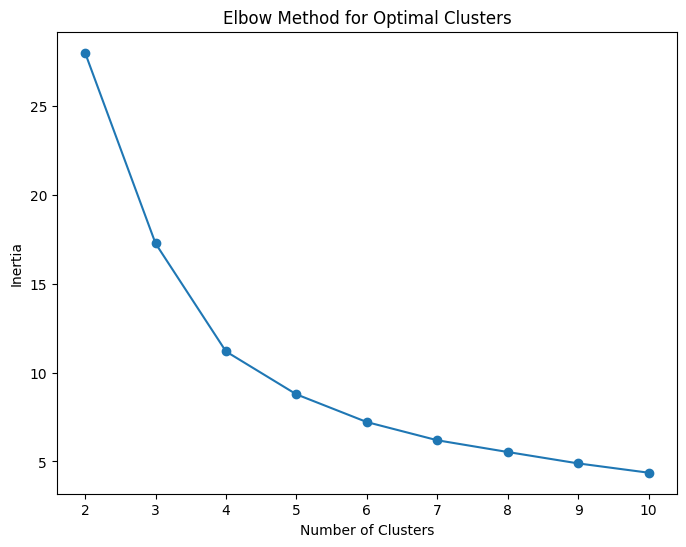

In [ ]:
# Elbow method to find optimal number of clusters
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia = []

for k in range(2, 11):  # Test between 1 and 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = 1000, init = "k-means++", max_iter = 10000 )
    kmeans.fit(cluster_data.drop(columns = "2023 Share of Renewable Energies"))
    inertia.append(kmeans.inertia_)
    cluster_data['Cluster'] = kmeans.predict(cluster_data.drop(columns = "2023 Share of Renewable Energies"))
    silhouette_avg = silhouette_score(cluster_data.drop(columns = "2023 Share of Renewable Energies"), cluster_data['Cluster'])
    print(f"For n_clusters = {k}, the average silhouette_score is : {silhouette_avg}")

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()


In [ ]:
result

,10 years evolution CO2 Emissions,2023 Share of Renewable Energies,10 years evolution Share of Renewables,10 years evolution Greenhouse Emissions
Entity,,,,
Afghanistan,0.130513,0.843373,-0.018695,0.118341
Albania,-0.144263,1.000000,0.000000,-0.086470
Algeria,0.187156,0.007724,0.003834,0.080871
Angola,-0.264267,0.754303,0.226060,-0.128185
Antigua and Barbuda,0.122581,0.057143,0.057143,0.243243
...,...,...,...,...
Venezuela,-0.554107,0.796657,0.237949,-0.586172
Vietnam,0.744577,0.425777,-0.015285,0.577570
Yemen,-0.589475,0.198675,0.197370,-0.451508


In [ ]:
from sklearn.cluster import KMeans

# Define the number of clusters

num_clusters = 4

# Fit K-Means
kmeans = KMeans(n_clusters=num_clusters,random_state=42, n_init = "auto",  max_iter = 10000)
cluster_data_2 = cluster_data.copy()
cluster_data_2['Cluster'] = kmeans.fit_predict(cluster_data_2.drop(columns = "2023 Share of Renewable Energies"))
cluster_data_2['Country'] = result.index


In [ ]:
cluster_data_2.head()

,10 years evolution CO2 Emissions,10 years evolution Share of Renewables,10 years evolution Greenhouse Emissions,2023 Share of Renewable Energies,Cluster,Country
0,0.130513,-0.018695,0.118341,0.843373,0,Afghanistan
1,-0.144263,0.000000,-0.086470,1.000000,2,Albania
2,0.187156,0.003834,0.080871,0.007724,0,Algeria
3,-0.264267,0.226060,-0.128185,0.754303,2,Angola
4,0.122581,0.057143,0.243243,0.057143,0,Antigua and Barbuda


<Axes: xlabel='Cluster', ylabel='count'>

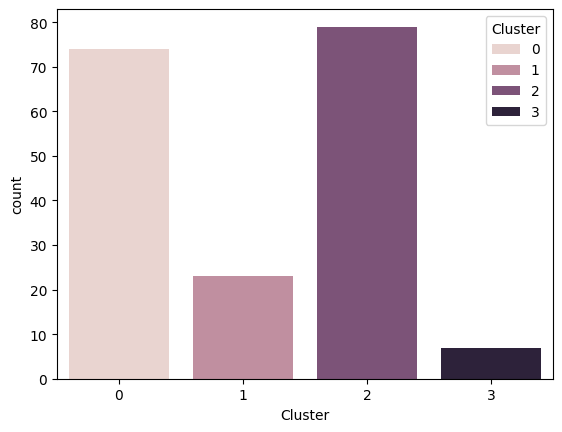

In [ ]:
import seaborn as sns
sns.countplot(cluster_data_2, x="Cluster", hue="Cluster")


**Seems like 2 or 5 clusters could be suitable, we'll proceed with 2 clusters!**

In [ ]:
pre_clust

,Year,Entity,share_of_renewable_energies,annual_co2_emissions,total_emissions,evolution_of_renewable_energies
2,2014,Chad,0.033333,2182780.0,66640000.00,0.033333
3,2015,Chad,0.033333,2351698.0,71230000.00,0.033333
4,2016,Chad,0.064516,2374447.0,75450004.00,0.064516
5,2017,Chad,0.062500,2344165.0,77980004.00,0.062500
6,2018,Chad,0.062500,2383510.0,82589999.97,0.062500
...,...,...,...,...,...,...
1993,2017,Saint Vincent and the Grenadines,0.133333,216176.0,300000.00,0.133333
1994,2018,Saint Vincent and the Grenadines,0.133333,241824.0,330000.00,0.133333
1995,2019,Saint Vincent and the Grenadines,0.133333,223504.0,300000.00,0.133333
1996,2020,Saint Vincent and the Grenadines,0.235294,238160.0,329999.99,0.235294


In [ ]:
pre_clust[pre_clust["Entity"] == "Laos"]

,Year,Entity,share_of_renewable_energies,annual_co2_emissions,total_emissions,evolution_of_renewable_energies
52,2014,Laos,1.000000,4449693.0,14690000.00,1.000000
53,2015,Laos,0.860149,9229252.0,19570000.00,0.860149
54,2016,Laos,0.687721,16458120.0,26880000.00,0.687721
55,2017,Laos,0.648214,19683848.0,30079999.97,0.648214
56,2018,Laos,0.650784,20558106.0,30599999.97,0.650784
57,2019,Laos,0.634763,19080390.0,30560000.00,0.634763
58,2020,Laos,0.715966,19491688.0,31060000.00,0.715966
59,2021,Laos,0.735530,22801204.0,35140000.00,0.735530


In [ ]:
 cluster_data_2[cluster_data_2['Cluster'] == 2].sort_values(by = "10 years evolution Share of Renewables")

,10 years evolution CO2 Emissions,10 years evolution Share of Renewables,10 years evolution Greenhouse Emissions,2023 Share of Renewable Energies,Cluster,Country
113,-0.031333,-0.156787,0.137438,0.829799,2,Mozambique
161,-0.158633,-0.065485,0.001477,0.046045,2,Syria
91,0.008819,-0.055978,0.071209,0.856011,2,Kyrgyzstan
41,-0.013962,-0.043245,0.004023,0.696889,2,Croatia
150,-0.037049,-0.035898,-0.024585,0.348942,2,Slovenia
...,...,...,...,...,...,...
74,0.074536,0.221580,0.052260,0.627604,2,Honduras
128,-0.028978,0.225585,0.021688,0.783650,2,Panama
86,-0.203109,0.226037,0.014057,0.229869,2,Jordan
3,-0.264267,0.226060,-0.128185,0.754303,2,Angola


In [ ]:
cluster_data_2.to_csv('cluster_countries.csv', index = False)

In [ ]:
import plotly

In [ ]:
import plotly.express as px

# Create the scatter plot
fig_scaled = px.scatter_3d(cluster_data_2,
                           x='10 years evolution CO2 Emissions',
                           y="10 years evolution Share of Renewables",
                           z='10 years evolution Greenhouse Emissions',
                           color=labelling,
                           text="Country",
                           width=1200,
                           height=800)

fig_scaled.show()


,Cluster
0,0
1,2
2,0
3,2
4,0
...,...
178,3
179,1
180,3
181,0


In [ ]:
import plotly.graph_objects as go
import plotly.express as px

# Define the color mapping based on cluster values
cluster_color_map = {
    '0': px.colors.qualitative.Bold[0],
    '1': px.colors.qualitative.Bold[2],
    '2': px.colors.qualitative.Bold[1],
    '3': px.colors.qualitative.Bold[3],
}

# Map the cluster labels to colors
labelling = cluster_data_2["Cluster"]
cluster_colors = labelling.astype('str').map(cluster_color_map)

# Create the scatter plot with custom colors
fig_scaled = px.scatter_3d(
    cluster_data_2,
    x='10 years evolution CO2 Emissions',
    y="10 years evolution Share of Renewables",
    z='10 years evolution Greenhouse Emissions',
    color=labelling.astype('str'),  # Cluster label as color
    text="Country",
    color_discrete_map=cluster_color_map,  # Apply the custom color map
    width=1200,
    height=800
)

# Convert to a graph_objects figure for further customization
fig = go.Figure(data=fig_scaled.data)

# Calculate dynamic ranges for x, y, and z
x_min, x_max = cluster_data_2['10 years evolution CO2 Emissions'].min(), cluster_data_2['10 years evolution CO2 Emissions'].max()
y_min, y_max = cluster_data_2['10 years evolution Share of Renewables'].min(), cluster_data_2['10 years evolution Share of Renewables'].max()
z_min, z_max = cluster_data_2['10 years evolution Greenhouse Emissions'].min(), cluster_data_2['10 years evolution Greenhouse Emissions'].max()

# Add planes for better visualization
fig.add_trace(go.Surface(
    z=[[z_min, z_min], [z_max, z_max]],
    x=[[0, 0], [0, 0]],
    y=[[y_min, y_max], [y_min, y_max]],
    colorscale=[[0, 'grey'], [1, 'grey']],
    opacity=0.2,
    showscale=False,
    name='Plane x=0'
))
fig.add_trace(go.Surface(
    z=[[z_min, z_min], [z_max, z_max]],
    x=[[x_min, x_max], [x_min, x_max]],
    y=[[0, 0], [0, 0]],
    colorscale=[[0, 'grey'], [1, 'grey']],
    opacity=0.2,
    showscale=False,
    name='Plane y=0'
))
fig.add_trace(go.Surface(
    z=[[0, 0], [0, 0]],
    x=[[x_min, x_max], [x_min, x_max]],
    y=[[y_min, y_min], [y_max, y_max]],
    colorscale=[[0, 'grey'], [1, 'grey']],
    opacity=0.2,
    showscale=False,
    name='Plane z=0'
))

# Update layout to reshape the entire figure
fig.update_layout(
    width=1200,
    height=800,
    scene=dict(
        xaxis=dict(title='10 years evolution CO2 Emissions', range=[x_min, x_max]),
        yaxis=dict(title='10 years evolution Share of Renewables', range=[y_min, y_max]),
        zaxis=dict(title='10 years evolution Greenhouse Emissions', range=[z_min, z_max]),
    ),
)

# Show the figure
fig.show()



**Cluster Summary:**

Here’s how you might summarize the clusters based on the cluster_summary data:

Cluster 0:

High CO₂ emissions: Largest annual emissions and CO₂ per capita.
Lower share of renewables: Indicates reliance on fossil fuels or limited renewable capacity.
Diverse electricity sources: Relatively higher contributions from solar and wind.
Populous countries: Includes nations with larger populations.

Cluster 1:

Low CO₂ emissions: Minimal annual emissions and CO₂ per capita.
High share of renewables: Particularly hydroelectricity.
Smaller countries: Lower population values suggest smaller or less industrialized nations.


# Forecasting:

In [ ]:
pip install prophet

In [ ]:
df

,Entity,Code,Year,Greenhouse_gas_emissions_from_agriculture,Greenhouse_gas_emissions_from_land_use_change_and_forestry,Greenhouse_gas_emissions_from_waste,Greenhouse_gas_emissions_from_buildings,Greenhouse_gas_emissions_from_industry,Greenhouse_gas_emissions_from_manufacturing_and_construction,Greenhouse_gas_emissions_from_transport,Greenhouse_gas_emissions_from_electricity_and_heat,Fugitive_emissions_of_greenhouse_gases_from_energy_production,Greenhouse_gas_emissions_from_other_fuel_combustion,Greenhouse_gas_emissions_from_bunker_fuels,join_key
0,Afghanistan,AFG,1990,8069999.5,-2390000.0,1230000.0,129999.99,50000.0,570000.0,970000.0,320000.0,280000.0,0.0,20000.00,AFG1990
1,Afghanistan,AFG,1991,8390000.0,-2390000.0,1320000.0,140000.00,60000.0,530000.0,930000.0,300000.0,240000.0,0.0,20000.00,AFG1991
2,Afghanistan,AFG,1992,8400000.0,-2390000.0,1400000.0,150000.00,60000.0,390000.0,740000.0,200000.0,200000.0,0.0,20000.00,AFG1992
3,Afghanistan,AFG,1993,8480000.0,-2390000.0,1490000.0,160000.00,60000.0,380000.0,740000.0,200000.0,160000.0,0.0,20000.00,AFG1993
4,Afghanistan,AFG,1994,8520000.0,-2390000.0,1580000.0,160000.00,60000.0,360000.0,730000.0,190000.0,120000.0,0.0,20000.00,AFG1994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6171,Zimbabwe,ZWE,2017,10780000.0,87290000.0,2540000.0,3600000.00,1680000.0,1260000.0,2069999.9,5130000.0,700000.0,410000.0,129999.99,ZWE2017
6172,Zimbabwe,ZWE,2018,10870000.0,87380000.0,2590000.0,3610000.00,1830000.0,1560000.0,2710000.0,5430000.0,710000.0,480000.0,160000.00,ZWE2018
6173,Zimbabwe,ZWE,2019,10620000.0,87330000.0,2640000.0,3530000.00,1810000.0,1630000.0,2320000.0,5020000.0,730000.0,440000.0,160000.00,ZWE2019
6174,Zimbabwe,ZWE,2020,9760000.0,87210000.0,2690000.0,3650000.00,1900000.0,1420000.0,1580000.0,3870000.0,750000.0,500000.0,60000.00,ZWE2020


In [ ]:
df.isna().sum()

,0
Entity,0
Code,0
ds,0
Other_renewables_excluding_bioenergy_TWh,0
Electricity_from_bioenergy_TWh,0
Electricity_from_solar_TWh,0
Electricity_from_wind_TWh,0
Electricity_from_hydro_TWh,0
Electricity_from_nuclear_TWh,0
Electricity_from_oil_TWh,0


In [ ]:
# Load your dataset
df = pd.read_csv("/content/electricity_production_sources_new.csv")  # Replace with your file path

# Rename columns for Prophet
df = df.rename(columns={"Year": "ds", "Share of Renewable Energy": "y"})
df['ds'] = pd.to_datetime(df['ds'], format='%Y')  # Ensure 'ds' is in datetime format

df = df[df["Entity"].isin(["India", "United States", "China", "Russia","Japan", "Iran", "Saudi Arabia", "Indonesia", "Germany", "South Korea", "Canada", "Brazil", "Mexico", "Turkey", "South Africa", "Australia", "Vietnam", "Italy", "United Kingdom", "Poland"])]

In [ ]:
df_population["join"] = df_population["Entity"].astype(str) + df_population["Year"].astype(str)
df_population.rename(columns = {"Population___Sex__all___Age__all___Variant__estimates":"Population"}, inplace = True)

In [ ]:
df_gdp = pd.read_csv("/content/gdp.csv")  # Replace with your file path
df_gdp["join"] = df_gdp["Entity"].astype(str) + df_gdp["Year"].astype(str)


In [ ]:
df.Entity.value_counts()

,count
Entity,
Iran,39
China,39
United States,39
South Africa,39
Saudi Arabia,39
South Korea,39
Indonesia,39
Australia,39
Vietnam,39


In [ ]:
df_population

,Entity,Code,Year,Population,join_key,join
0,Aruba,ABW,1950,42763,ABW1950,Aruba1950
1,Aruba,ABW,1951,43880,ABW1951,Aruba1951
2,Aruba,ABW,1952,45052,ABW1952,Aruba1952
3,Aruba,ABW,1953,46269,ABW1953,Aruba1953
4,Aruba,ABW,1954,47516,ABW1954,Aruba1954
...,...,...,...,...,...,...
17533,Kosovo,OWID_KOS,2019,1755048,OWID_KOS2019,Kosovo2019
17534,Kosovo,OWID_KOS,2020,1751415,OWID_KOS2020,Kosovo2020
17535,Kosovo,OWID_KOS,2021,1741449,OWID_KOS2021,Kosovo2021
17536,Kosovo,OWID_KOS,2022,1717950,OWID_KOS2022,Kosovo2022


In [ ]:
df_gdp

,Entity,Code,Year,GDP_per_capita,join_key,Income_group,join
0,East Asia and Pacific (WB),NaN,1990,5159.8990,NaN,NaN,East Asia and Pacific (WB)1990
1,East Asia and Pacific (WB),NaN,1991,5362.9870,NaN,NaN,East Asia and Pacific (WB)1991
2,East Asia and Pacific (WB),NaN,1992,5565.1743,NaN,NaN,East Asia and Pacific (WB)1992
3,East Asia and Pacific (WB),NaN,1993,5775.2200,NaN,NaN,East Asia and Pacific (WB)1993
4,East Asia and Pacific (WB),NaN,1994,6047.4810,NaN,NaN,East Asia and Pacific (WB)1994
...,...,...,...,...,...,...,...
6557,South Africa,ZAF,2018,13995.0625,ZAF2018,Upper middle income,South Africa2018
6558,South Africa,ZAF,2019,13850.8955,ZAF2019,Upper middle income,South Africa2019
6559,South Africa,ZAF,2020,12866.5690,ZAF2020,Upper middle income,South Africa2020
6560,South Africa,ZAF,2021,13337.7900,ZAF2021,Upper middle income,South Africa2021


In [ ]:
df = df[["ds","Entity","share_of_renewable_energies"]]

df.dropna(inplace = True)

df = df.rename(columns={"share_of_renewable_energies": "y"})

<ipython-input-118-1deac951e2ef>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/8rz3utod.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/hn496fft.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42971', 'data', 'file=/tmp/tmp0t3zvqo3/8rz3utod.json', 'init=/tmp/tmp0t3zvqo3/hn496fft.json', 'output', 'file=/tmp/tmp0t3zvqo3/prophet_model38qjj191/prophet_model-20241205093551.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:35:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iran


09:35:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/uvw479e1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/e8x0w53s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4948', 'data', 'file=/tmp/tmp0t3zvqo3/uvw479e1.json', 'init=/tmp/tmp0t3zvqo3/e8x0w53s.json', 'output', 'file=/tmp/tmp0t3zvqo3/prophet_modeltcso3i2z/prophet_model-20241205093552.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:35:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


China


09:35:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/ra26srad.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/ksp45cwx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21887', 'data', 'file=/tmp/tmp0t3zvqo3/ra26srad.json', 'init=/tmp/tmp0t3zvqo3/ksp45cwx.json', 'output', 'file=/tmp/tmp0t3zvqo3/prophet_modelyjrgsh32/prophet_model-20241205093552.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:35:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


India


09:35:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/h5rv2kvn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/kimaiv84.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93541', 'data', 'file=/tmp/tmp0t3zvqo3/h5rv2kvn.json', 'init=/tmp/tmp0t3zvqo3/kimaiv84.json', 'output', 'file=/tmp/tmp0t3zvqo3/prophet_modelk23uzwhs/prophet_model-20241205093553.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:35:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Italy


09:35:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/_eoyt5x0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/x0kt9ffu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41560', 'data', 'file=/tmp/tmp0t3zvqo3/_eoyt5x0.json', 'init=/tmp/tmp0t3zvqo3/x0kt9ffu.json', 'output', 'file=/tmp/tmp0t3zvqo3/prophet_modeldlymzyyw/prophet_model-20241205093554.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:35:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Japan


09:35:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/1pyp5hd2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/kb7w0vyj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64248', 'data', 'file=/tmp/tmp0t3zvqo3/1pyp5hd2.json', 'init=/tmp/tmp0t3zvqo3/kb7w0vyj.json', 'output', 'file=/tmp/tmp0t3zvqo3/prophet_modeljkrw78ra/prophet_model-20241205093554.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:35:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Brazil


09:35:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/pp35618n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/0fxy7bvy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24013', 'data', 'file=/tmp/tmp0t3zvqo3/pp35618n.json', 'init=/tmp/tmp0t3zvqo3/0fxy7bvy.json', 'output', 'file=/tmp/tmp0t3zvqo3/prophet_modelodv795sh/prophet_model-20241205093555.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:35:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Canada


09:35:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/dcypleol.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/wx5w07df.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29648', 'data', 'file=/tmp/tmp0t3zvqo3/dcypleol.json', 'init=/tmp/tmp0t3zvqo3/wx5w07df.json', 'output', 'file=/tmp/tmp0t3zvqo3/prophet_modeli82e8srk/prophet_model-20241205093555.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:35:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mexico


09:35:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/hdbd1x0v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/au_pi3td.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17757', 'data', 'file=/tmp/tmp0t3zvqo3/hdbd1x0v.json', 'init=/tmp/tmp0t3zvqo3/au_pi3td.json', 'output', 'file=/tmp/tmp0t3zvqo3/prophet_modelm5gimazr/prophet_model-20241205093556.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:35:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Poland


09:35:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/6ue1ap8h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/t4n9vhnf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82734', 'data', 'file=/tmp/tmp0t3zvqo3/6ue1ap8h.json', 'init=/tmp/tmp0t3zvqo3/t4n9vhnf.json', 'output', 'file=/tmp/tmp0t3zvqo3/prophet_modellusbdet1/prophet_model-20241205093556.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:35:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Russia


09:35:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/lnqkny9h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/_zdlkk7e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53153', 'data', 'file=/tmp/tmp0t3zvqo3/lnqkny9h.json', 'init=/tmp/tmp0t3zvqo3/_zdlkk7e.json', 'output', 'file=/tmp/tmp0t3zvqo3/prophet_modelxguriw2n/prophet_model-20241205093557.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:35:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Turkey


09:35:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/zxs8wwl0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/q9mrew2o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75876', 'data', 'file=/tmp/tmp0t3zvqo3/zxs8wwl0.json', 'init=/tmp/tmp0t3zvqo3/q9mrew2o.json', 'output', 'file=/tmp/tmp0t3zvqo3/prophet_modelpwlnv33r/prophet_model-20241205093557.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:35:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Germany


09:35:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/5emkdcqy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/vsdksdky.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81527', 'data', 'file=/tmp/tmp0t3zvqo3/5emkdcqy.json', 'init=/tmp/tmp0t3zvqo3/vsdksdky.json', 'output', 'file=/tmp/tmp0t3zvqo3/prophet_modelw5fq29yl/prophet_model-20241205093558.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:35:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Vietnam


09:35:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/myge3psh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/8wbky04n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38092', 'data', 'file=/tmp/tmp0t3zvqo3/myge3psh.json', 'init=/tmp/tmp0t3zvqo3/8wbky04n.json', 'output', 'file=/tmp/tmp0t3zvqo3/prophet_modely7nj_hsy/prophet_model-20241205093558.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:35:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Australia


09:35:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/7b6ucb67.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/q5_a6uor.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6187', 'data', 'file=/tmp/tmp0t3zvqo3/7b6ucb67.json', 'init=/tmp/tmp0t3zvqo3/q5_a6uor.json', 'output', 'file=/tmp/tmp0t3zvqo3/prophet_model7lad_p91/prophet_model-20241205093559.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:35:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Indonesia


09:35:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/sc9pumyr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/hypu36he.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56896', 'data', 'file=/tmp/tmp0t3zvqo3/sc9pumyr.json', 'init=/tmp/tmp0t3zvqo3/hypu36he.json', 'output', 'file=/tmp/tmp0t3zvqo3/prophet_modelku6h5yb7/prophet_model-20241205093559.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:35:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


South Korea


09:36:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/znc4dsxd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/vxccrcqg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42958', 'data', 'file=/tmp/tmp0t3zvqo3/znc4dsxd.json', 'init=/tmp/tmp0t3zvqo3/vxccrcqg.json', 'output', 'file=/tmp/tmp0t3zvqo3/prophet_modelmv_jx2fi/prophet_model-20241205093600.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:36:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Saudi Arabia


09:36:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/1mvxt0gm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/lap3fnvi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66101', 'data', 'file=/tmp/tmp0t3zvqo3/1mvxt0gm.json', 'init=/tmp/tmp0t3zvqo3/lap3fnvi.json', 'output', 'file=/tmp/tmp0t3zvqo3/prophet_modelcg0g8xqy/prophet_model-20241205093600.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:36:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


South Africa


09:36:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/kz84eihe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/uatsmrmr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61544', 'data', 'file=/tmp/tmp0t3zvqo3/kz84eihe.json', 'init=/tmp/tmp0t3zvqo3/uatsmrmr.json', 'output', 'file=/tmp/tmp0t3zvqo3/prophet_modelh3rb_xm1/prophet_model-20241205093601.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:36:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


United States


09:36:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/x76oudby.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0t3zvqo3/buzkcw2i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47978', 'data', 'file=/tmp/tmp0t3zvqo3/x76oudby.json', 'init=/tmp/tmp0t3zvqo3/buzkcw2i.json', 'output', 'file=/tmp/tmp0t3zvqo3/prophet_model_cvk646n/prophet_model-20241205093602.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:36:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


United Kingdom


09:36:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


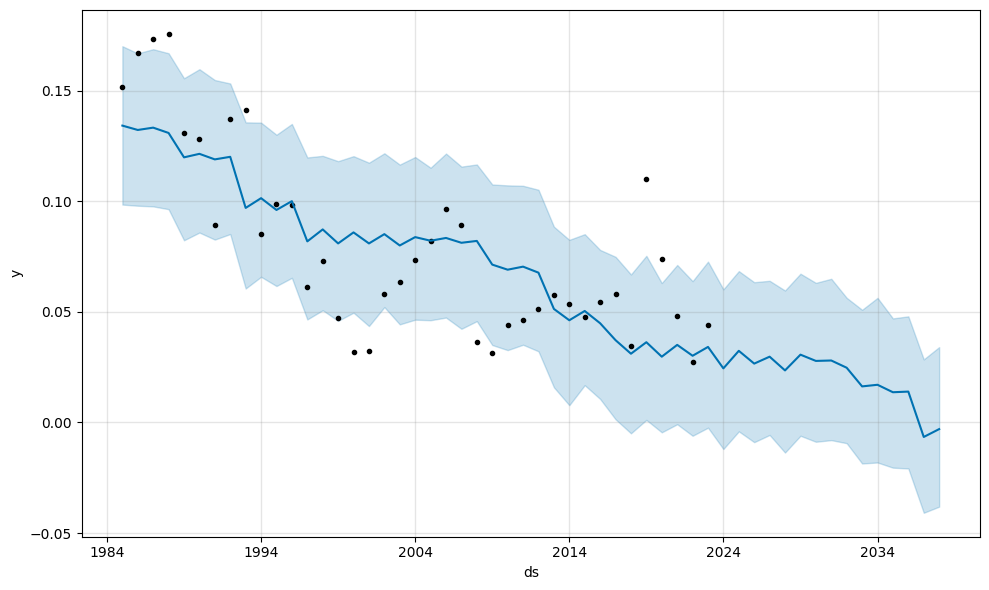

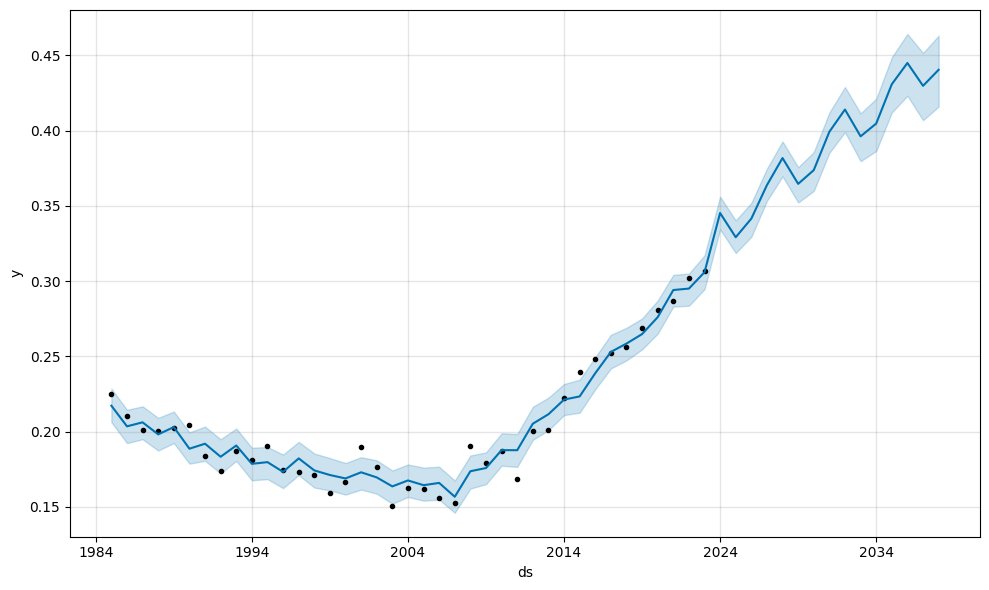

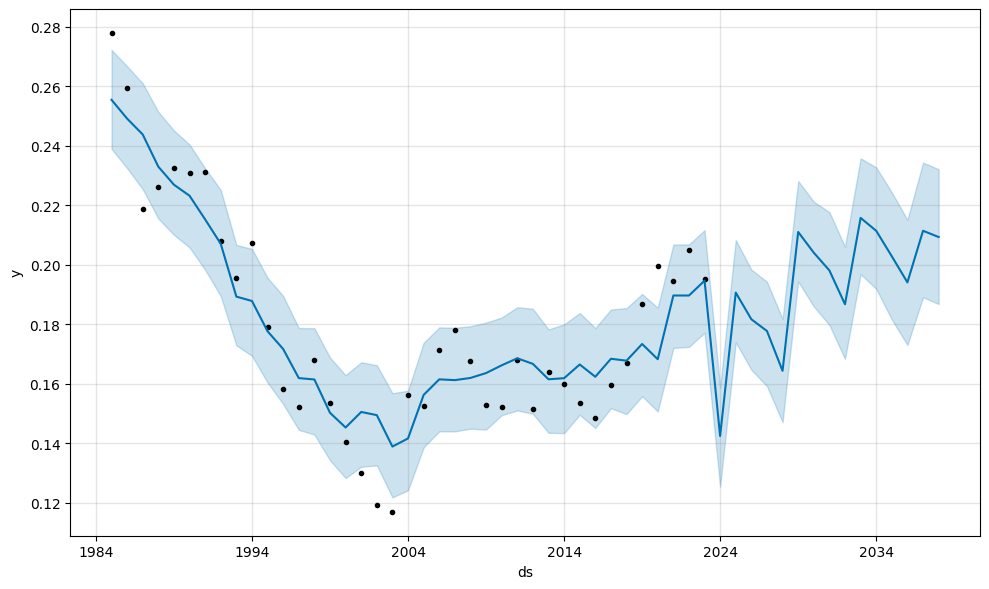

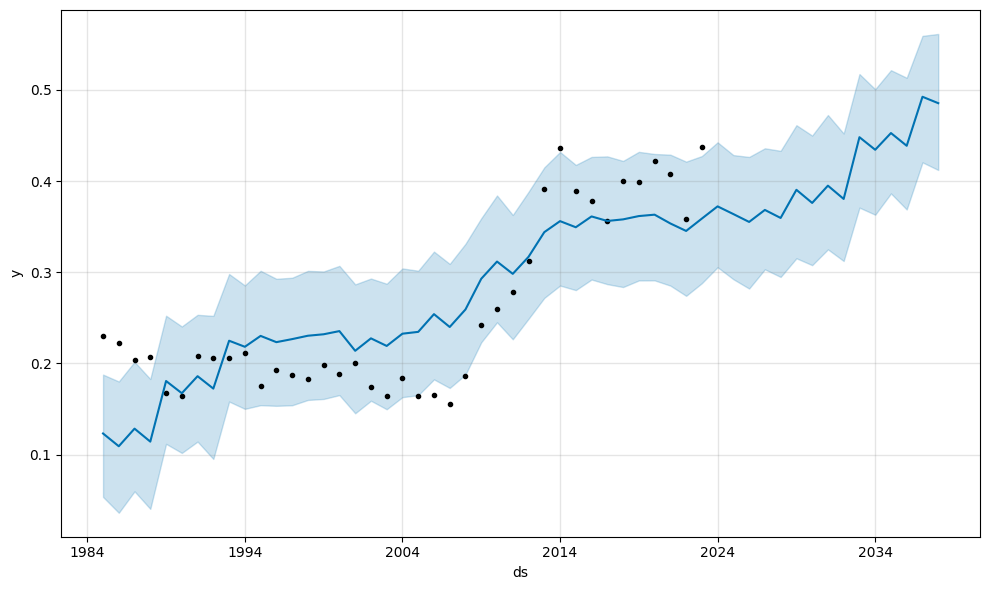

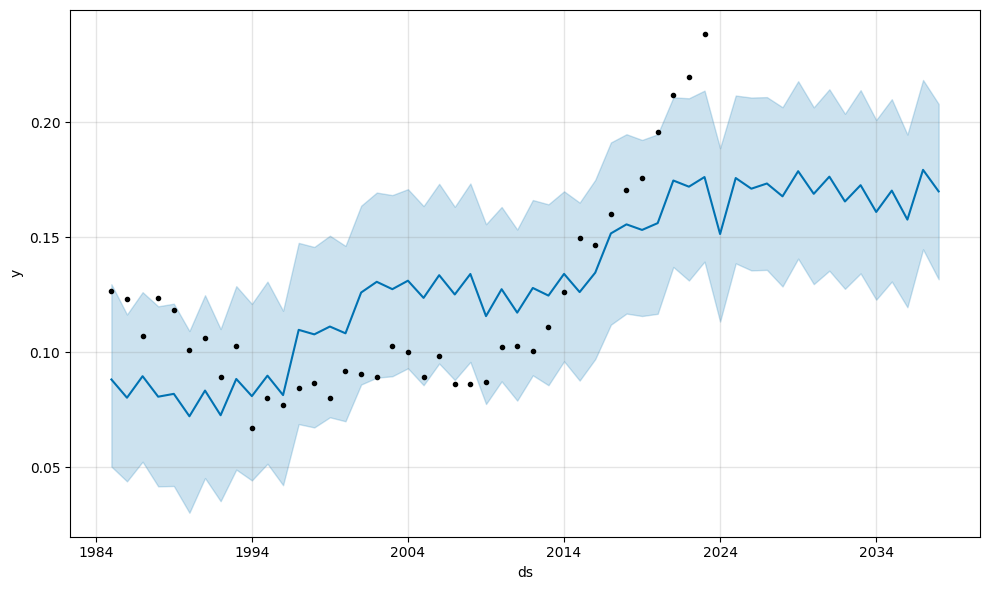

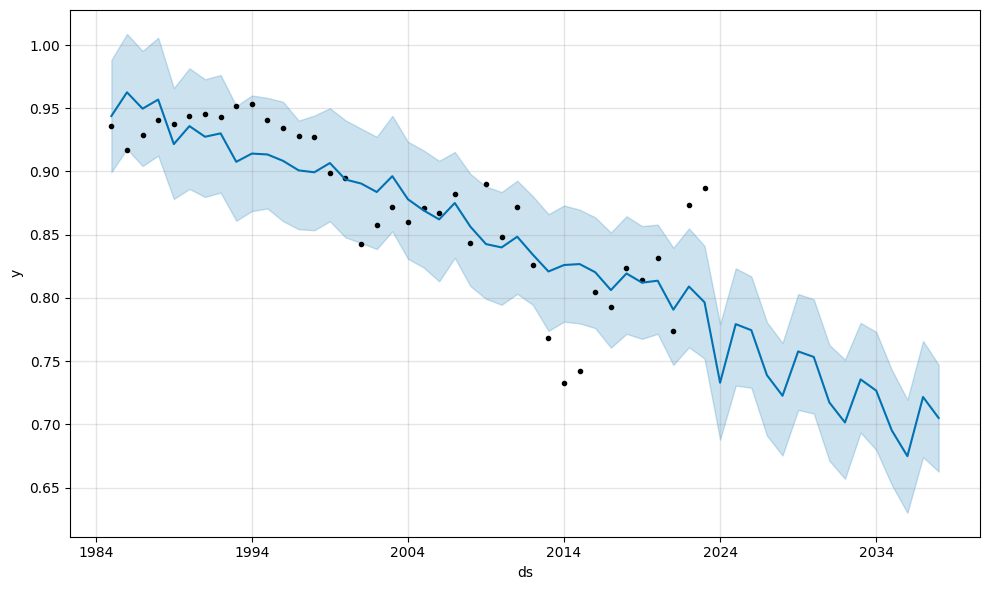

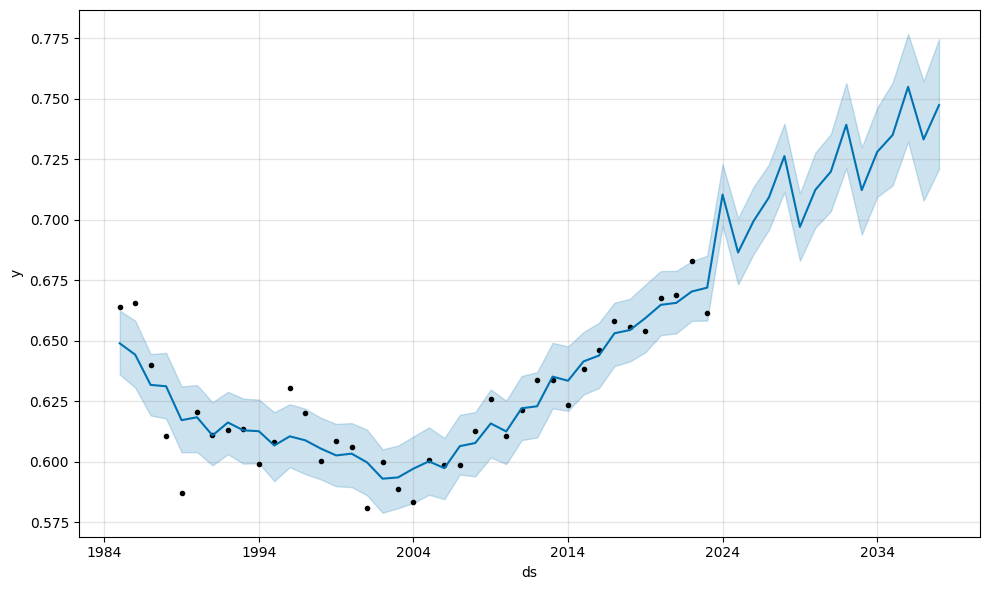

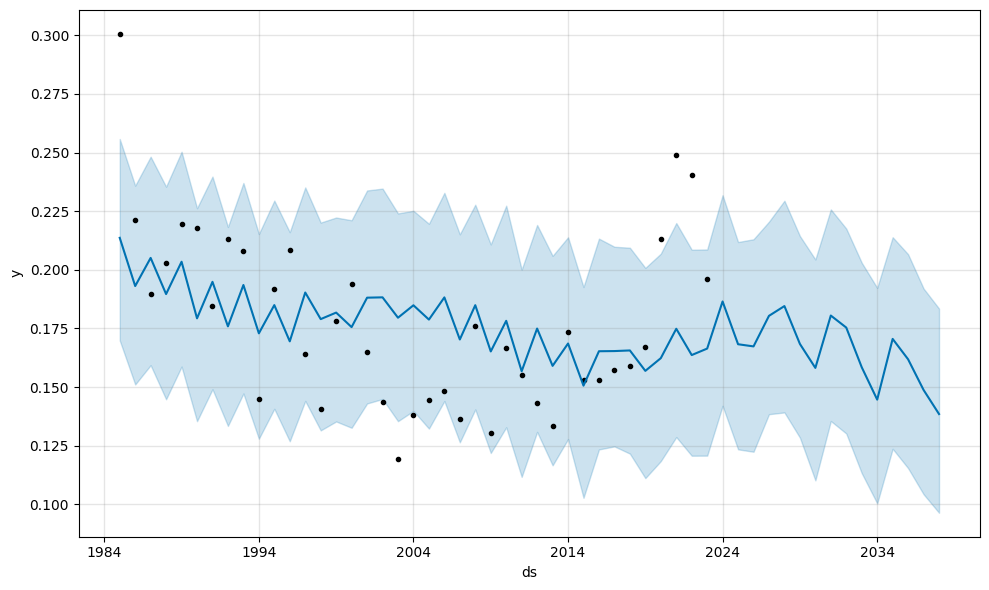

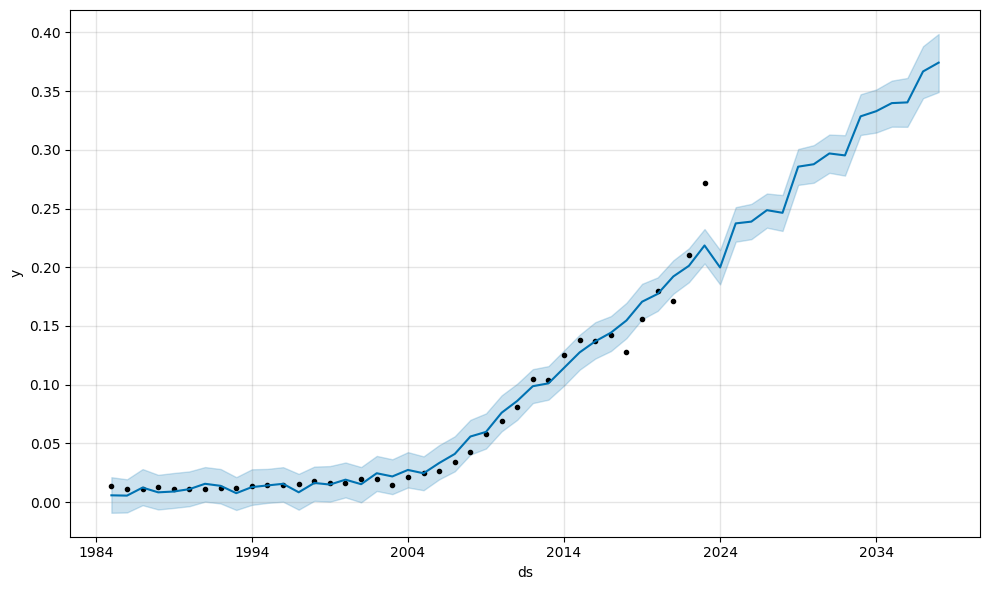

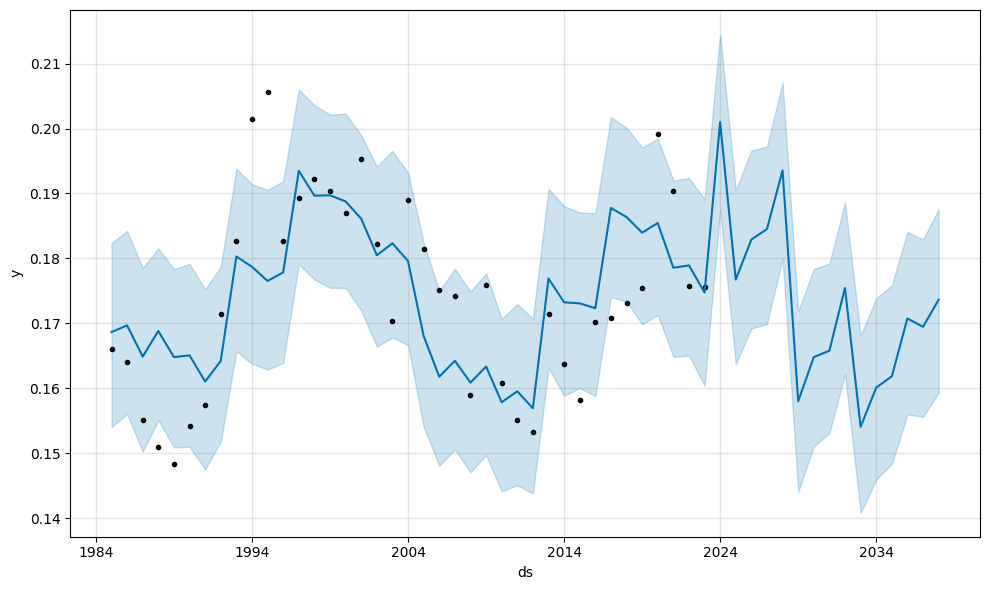

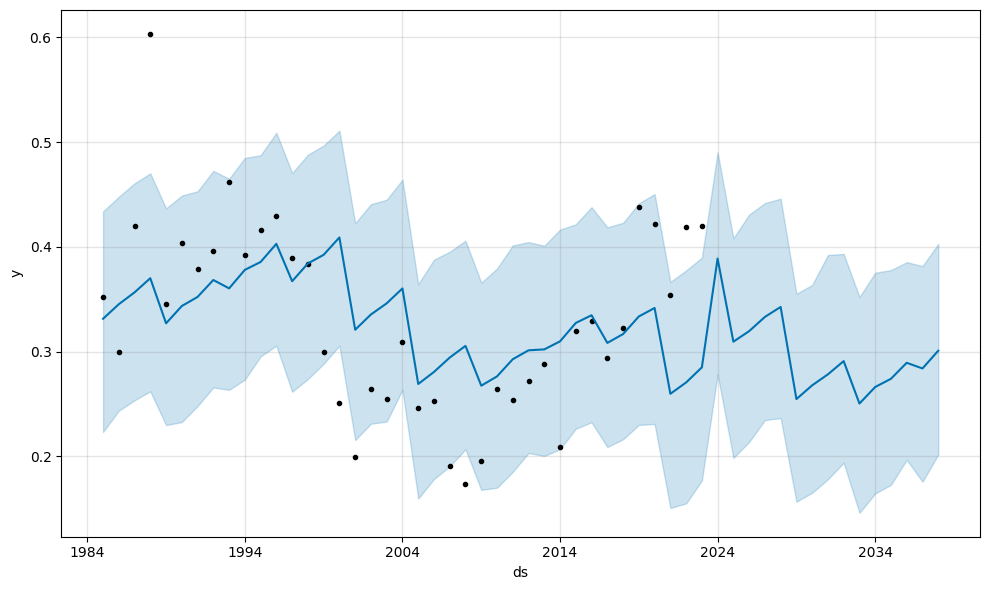

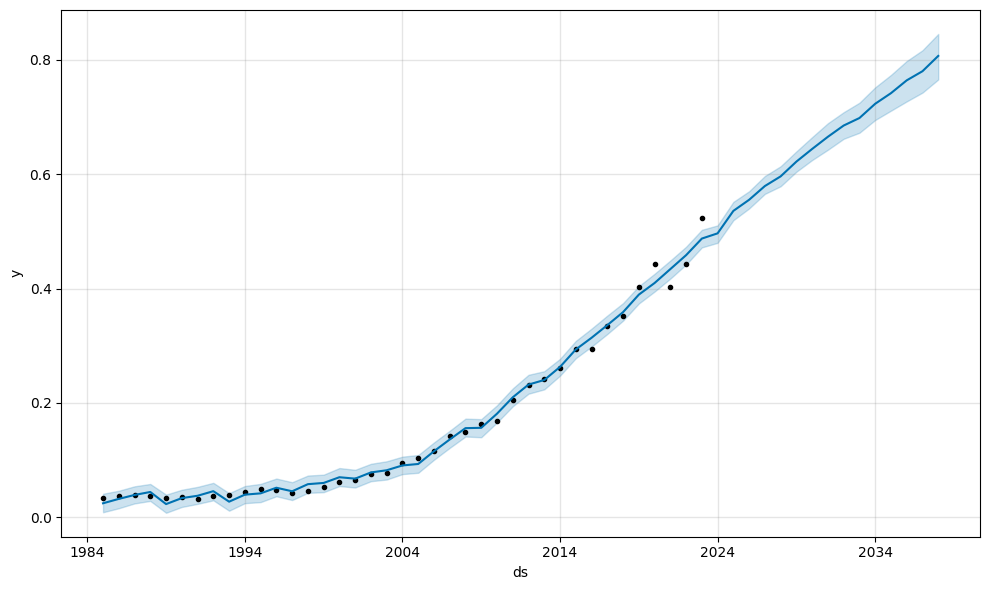

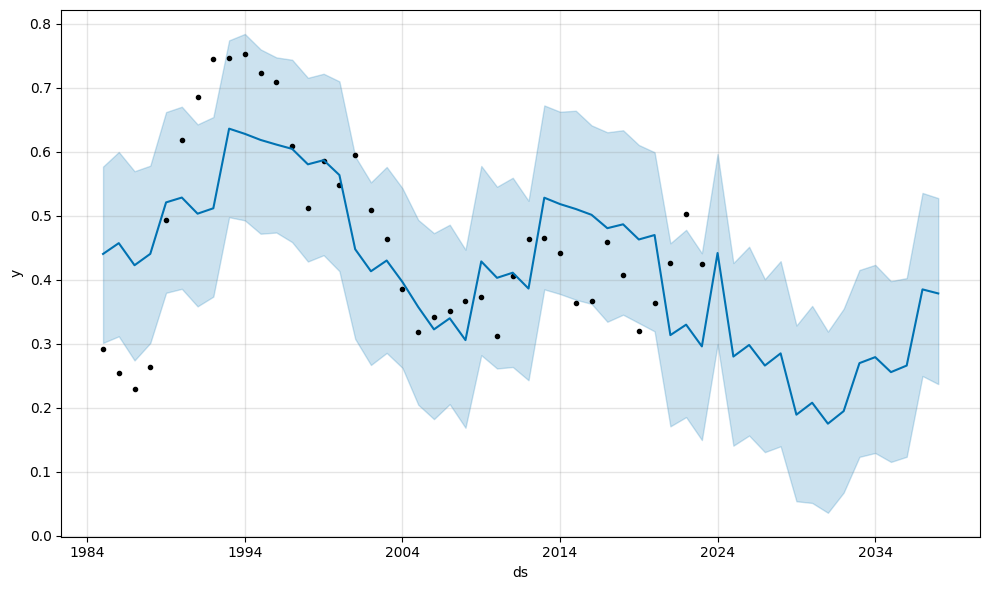

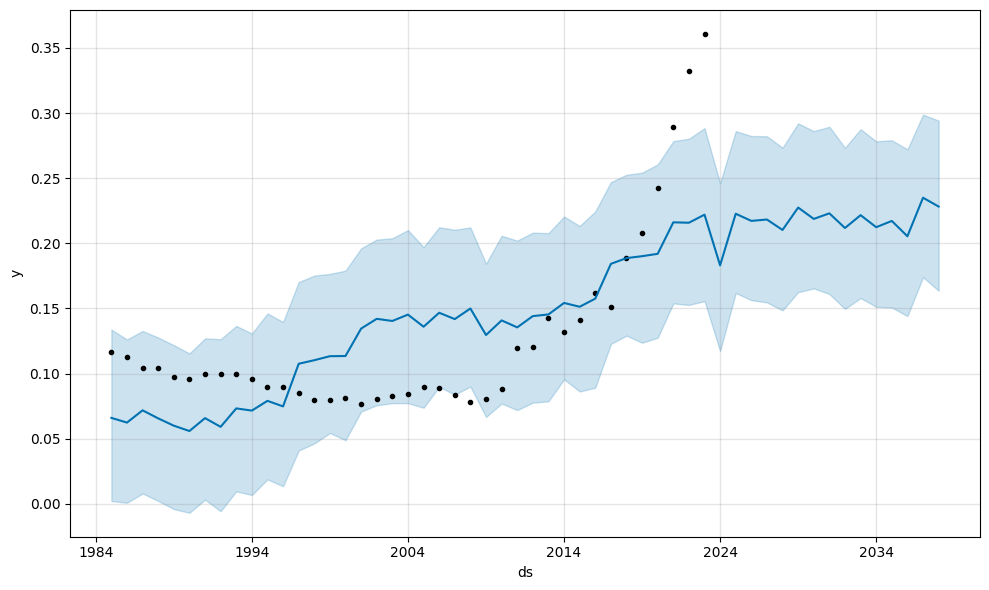

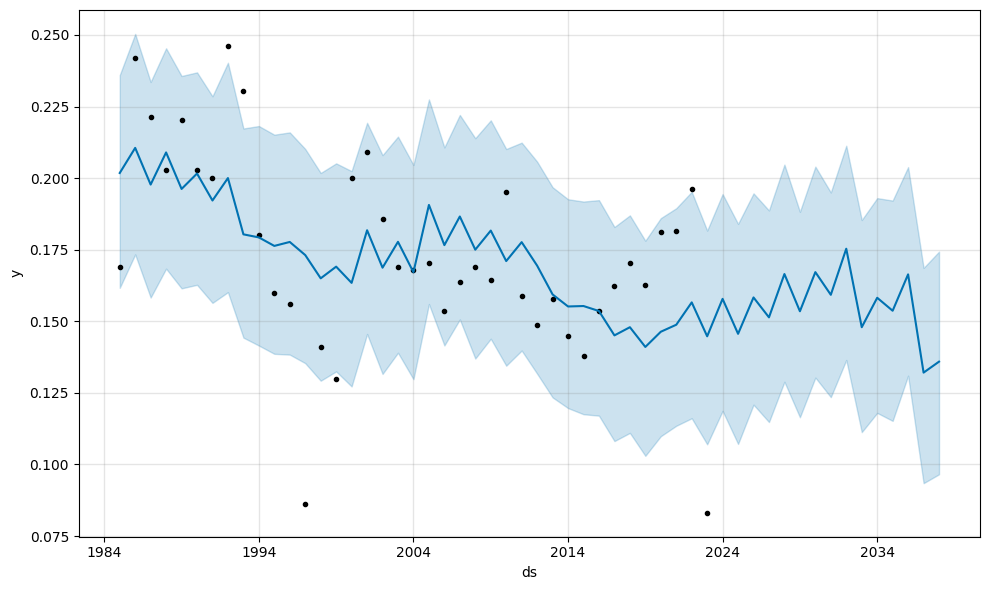

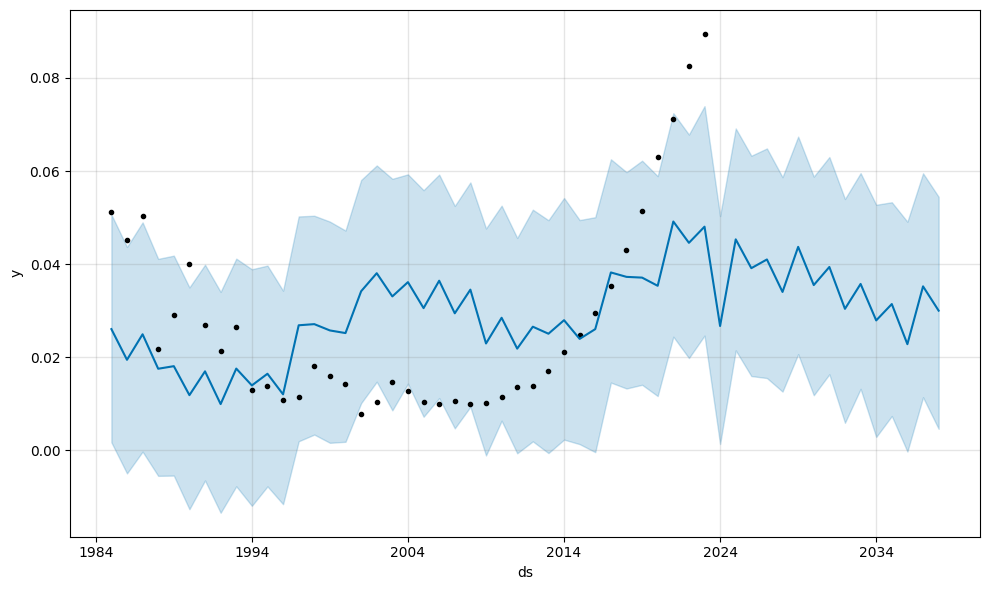

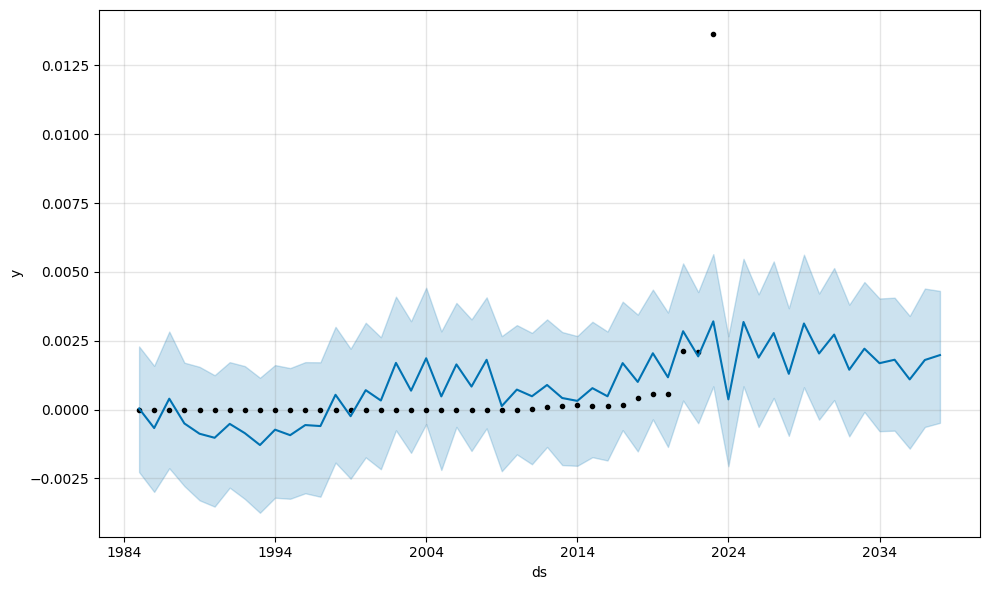

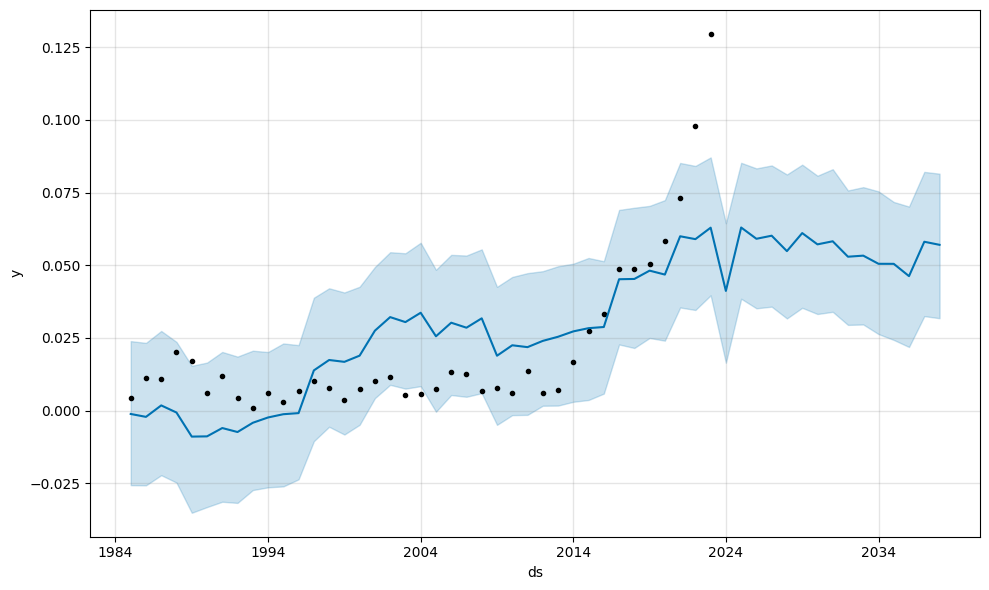

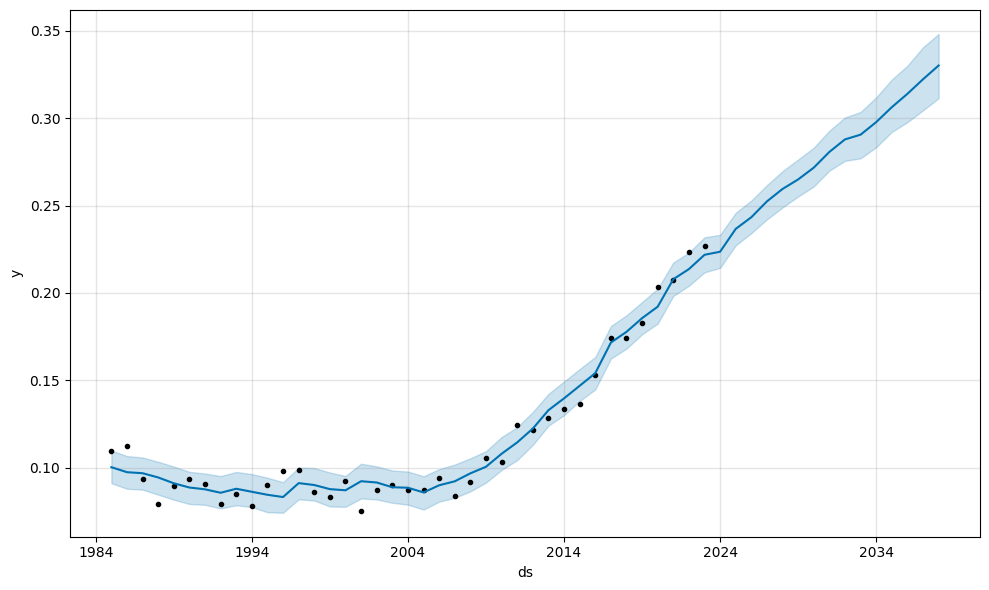

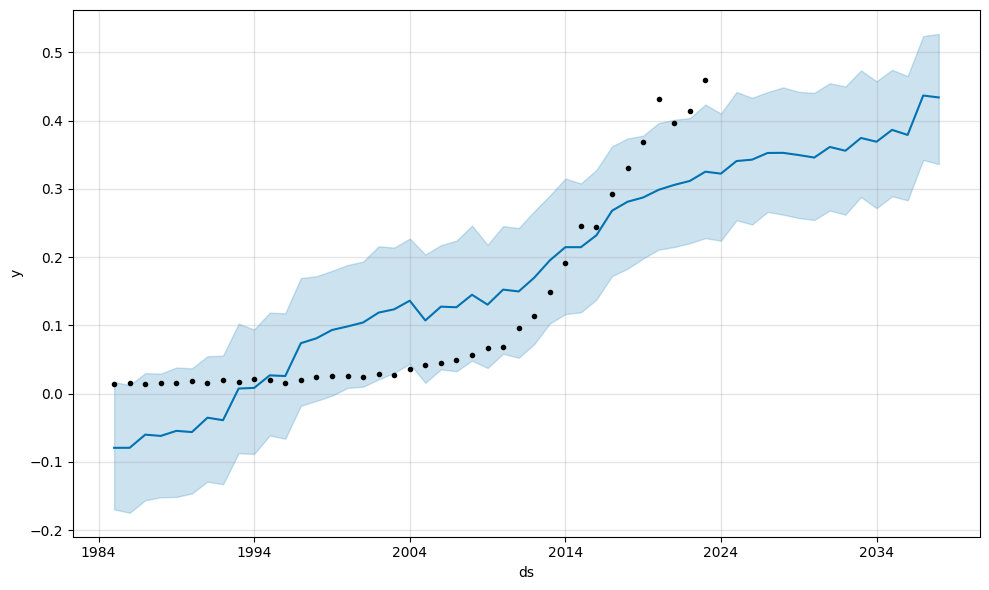

In [ ]:
import pandas as pd
from prophet import Prophet


# Get unique countries
countries = df['Entity'].unique()

# Initialize a dictionary to store forecasts
forecasts = {}

# Loop through each country and forecast
for country in countries:

    print(country)
    country_data = df[df['Entity'] == country][['ds', 'y']].sort_values('ds')

    # Initialize and fit the Prophet model
    model = Prophet(seasonality_mode = "additive", changepoint_range =.7)
    model.add_seasonality(name='policy_cycle', period=10, fourier_order=2)

    model.fit(country_data)

    # Create future dataframe until 2030
    future = model.make_future_dataframe(periods=15, freq='YE')
    forecast = model.predict(future)

    # Save the forecast
    forecasts[country] = forecast

    # Optional: Plot forecast
    model.plot(forecast)


In [ ]:
forecasts["United Kingdom"]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,policy_cycle,policy_cycle_lower,policy_cycle_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1985-01-01,-0.047842,-0.169432,0.017292,-0.047842,-0.047842,-0.031475,-0.031475,-0.031475,-0.008112,-0.008112,-0.008112,-0.023363,-0.023363,-0.023363,0.0,0.0,0.0,-0.079317
1,1986-01-01,-0.038021,-0.174442,0.012386,-0.038021,-0.038021,-0.041228,-0.041228,-0.041228,-0.018164,-0.018164,-0.018164,-0.023063,-0.023063,-0.023063,0.0,0.0,0.0,-0.079248
2,1987-01-01,-0.028199,-0.156075,0.030099,-0.028199,-0.028199,-0.031823,-0.031823,-0.031823,-0.008112,-0.008112,-0.008112,-0.023711,-0.023711,-0.023711,0.0,0.0,0.0,-0.060022
3,1988-01-01,-0.018377,-0.151718,0.029381,-0.018377,-0.018377,-0.043469,-0.043469,-0.043469,-0.018164,-0.018164,-0.018164,-0.025304,-0.025304,-0.025304,0.0,0.0,0.0,-0.061846
4,1989-01-01,-0.008529,-0.151262,0.038314,-0.008529,-0.008529,-0.045923,-0.045923,-0.045923,-0.022560,-0.022560,-0.022560,-0.023363,-0.023363,-0.023363,0.0,0.0,0.0,-0.054452
5,1990-01-01,0.001293,-0.146117,0.037083,0.001293,0.001293,-0.057525,-0.057525,-0.057525,-0.034462,-0.034462,-0.034462,-0.023063,-0.023063,-0.023063,0.0,0.0,0.0,-0.056232
6,1991-01-01,0.011115,-0.128809,0.054839,0.011115,0.011115,-0.046271,-0.046271,-0.046271,-0.022560,-0.022560,-0.022560,-0.023711,-0.023711,-0.023711,0.0,0.0,0.0,-0.035156
7,1992-01-01,0.020936,-0.132687,0.055720,0.020936,0.020936,-0.059766,-0.059766,-0.059766,-0.034462,-0.034462,-0.034462,-0.025304,-0.025304,-0.025304,0.0,0.0,0.0,-0.038830
8,1993-01-01,0.030785,-0.087191,0.102426,0.030785,0.030785,-0.023243,-0.023243,-0.023243,0.000120,0.000120,0.000120,-0.023363,-0.023363,-0.023363,0.0,0.0,0.0,0.007542
9,1994-01-01,0.040607,-0.088225,0.094042,0.040607,0.040607,-0.032149,-0.032149,-0.032149,-0.009085,-0.009085,-0.009085,-0.023063,-0.023063,-0.023063,0.0,0.0,0.0,0.008458


In [ ]:
df_list = []

for country, country_data in forecasts.items():
    # Create a dataframe for the country
    df = pd.DataFrame(country_data)
    # Add a column for the country name
    df['country'] = country
    # Append to the list
    df_list.append(df)

# Concatenate all dataframes into a single dataframe
combined_df = pd.concat(df_list, ignore_index=True)

# Display the combined dataframe
print(combined_df)

             ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    1985-01-01 -0.002782    0.098458    0.170019    -0.002782    -0.002782   
1    1986-01-01 -0.005301    0.097940    0.166775    -0.005301    -0.005301   
2    1987-01-01 -0.007820    0.097641    0.168661    -0.007820    -0.007820   
3    1988-01-01 -0.010338    0.096382    0.166835    -0.010338    -0.010338   
4    1989-01-01 -0.012864    0.082324    0.155537    -0.012864    -0.012864   
...         ...       ...         ...         ...          ...          ...   
1075 2033-12-31  0.434826    0.271697    0.457523     0.434781     0.434870   
1076 2034-12-31  0.444685    0.289251    0.474304     0.444634     0.444736   
1077 2035-12-31  0.454545    0.283222    0.465135     0.454487     0.454604   
1078 2036-12-31  0.464431    0.342362    0.523824     0.464366     0.464498   
1079 2037-12-31  0.474291    0.336259    0.526923     0.474220     0.474364   

      additive_terms  additive_terms_lower  additiv

In [ ]:
combined_df[["ds","trend", "yhat","yhat_lower","yhat_upper","trend_lower", "trend_upper", "country"]]

,ds,trend,yhat,yhat_lower,yhat_upper,trend_lower,trend_upper,country
0,1985-01-01,-0.002782,0.134143,0.098458,0.170019,-0.002782,-0.002782,Iran
1,1986-01-01,-0.005301,0.132169,0.097940,0.166775,-0.005301,-0.005301,Iran
2,1987-01-01,-0.007820,0.133221,0.097641,0.168661,-0.007820,-0.007820,Iran
3,1988-01-01,-0.010338,0.130824,0.096382,0.166835,-0.010338,-0.010338,Iran
4,1989-01-01,-0.012864,0.119798,0.082324,0.155537,-0.012864,-0.012864,Iran
...,...,...,...,...,...,...,...,...
1075,2033-12-31,0.434826,0.369044,0.271697,0.457523,0.434781,0.434870,United Kingdom
1076,2034-12-31,0.444685,0.386393,0.289251,0.474304,0.444634,0.444736,United Kingdom
1077,2035-12-31,0.454545,0.379012,0.283222,0.465135,0.454487,0.454604,United Kingdom
1078,2036-12-31,0.464431,0.436709,0.342362,0.523824,0.464366,0.464498,United Kingdom


In [ ]:
# Add the new columns based on the condition
combined_df['real_share'] = combined_df['yhat'].where(combined_df['ds'].dt.year <= 2023)
combined_df['predicted_share'] = combined_df['yhat'].where(combined_df['ds'].dt.year >= 2023)
combined_df['y_hat_upper'] = combined_df['yhat_upper'].where(combined_df['ds'].dt.year >= 2023)
combined_df['y_hat_lower'] = combined_df['yhat_lower'].where(combined_df['ds'].dt.year >= 2023)
print(combined_df.shape)


goals_per_country = {
    "India": 0.423,
    "United States": 0.5965,
    "China":0.60,
    "Russia": 0.60,
    "Japan":0.38,
    "Iran":0.60,
    "Saudi Arabia": 0.5,
    "Indonesia":0.4365,
    "Germany": 0.75,
    "South Korea":0.2023,
    "Canada": 0.724,
    "Brazil": 0.8426,
    "Mexico":0.3326,
    "Turkey":0.473,
    "South Africa":0.325,
    "Australia": 0.8115,
    "Vietnam":0.21,
    "Italy":0.6865,
    "United Kingdom": 0.8536,
    "Poland":0.5141
    # Add more countries and goals as needed
}

goals_year = {
    "India": 2030,
    "United States": 2030,
    "China":2035,
    "Russia": 2030,
    "Japan":2030,
    "Iran": 2030,
    "Saudi Arabia": 2030,
    "Indonesia":2030,
    "Germany": 2030,
    "South Korea":2030,
    "Canada": 2030,
    "Brazil": 2030,
    "Mexico":2030,
    "Turkey":2030,
    "South Africa":2030,
    "Australia": 2030,
    "Vietnam":2030,
    "Italy":2030,
    "United Kingdom": 2030,
    "Poland":2030
    # Add more countries and goals as needed
}

combined_df['goal'] = combined_df['country'].map(goals_per_country)
combined_df['goal_year'] = combined_df['country'].map(goals_year)


combined_df_2 = combined_df[["ds", "country","y_hat_lower", "y_hat_upper", "real_share", "predicted_share","goal", "goal_year"]].melt(id_vars = ["ds", "country"])

combined_df_2



(1080, 26)


,ds,country,variable,value
0,1985-01-01,Iran,y_hat_lower,NaN
1,1986-01-01,Iran,y_hat_lower,NaN
2,1987-01-01,Iran,y_hat_lower,NaN
3,1988-01-01,Iran,y_hat_lower,NaN
4,1989-01-01,Iran,y_hat_lower,NaN
...,...,...,...,...
6475,2033-12-31,United Kingdom,goal_year,2030.0
6476,2034-12-31,United Kingdom,goal_year,2030.0
6477,2035-12-31,United Kingdom,goal_year,2030.0
6478,2036-12-31,United Kingdom,goal_year,2030.0


In [ ]:
combined_df_2.to_csv("predictions.csv", index = False)